#### Import Necessary Libraries

In [84]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
	mean_absolute_error,
	mean_squared_error,
	r2_score,
	classification_report,
	roc_auc_score,
	RocCurveDisplay,
	ConfusionMatrixDisplay
)
from prophet import Prophet
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


#### Data Cleaning

**The Olist Customers dataset**

Possible duplicate customers can appear since `customer_unique_id` is the true unique user identifier, and there may be null or inconsistent city/state values.

In [86]:
# Load dataset
customers = pd.read_csv('olist_customers_dataset.csv')

# Drop duplicates based on customeruniqueid to get unique customers
customers_cleaned = customers.drop_duplicates(subset='customer_unique_id')

# Standardize city and state text (strip whitespace, lower case)
customers_cleaned['customer_city'] = customers_cleaned['customer_city'].str.strip().str.lower()
customers_cleaned['customer_state'] = customers_cleaned['customer_state'].str.strip().str.upper()

# Drop rows with missing essential location data
customers_cleaned = customers_cleaned.dropna(subset=['customer_city', 'customer_state'])

# Reset index 
customers_cleaned = customers_cleaned.reset_index(drop=True)
# Display cleaned data
customers_cleaned.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_15316\1075034012.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp\ipykernel_15316\1075034012.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

We removed duplicate customers based on their unique user ID, cleans whitespace and standardizes case for city and state names, and removes entries with missing location data.

**The Olist Geolocation dataset**

Some city names have inconsistent spellings (e.g., "so paulo" instead of "sao paulo") and coordinates might have outliers.

In [87]:
geoloc = pd.read_csv('olist_geolocation_dataset.csv')

# Fix known city name typos
geoloc['geolocation_city'] = geoloc['geolocation_city'].str.replace('so paulo', 'sao paulo').str.lower().str.strip()
geoloc['geolocation_state'] = geoloc['geolocation_state'].str.strip().str.upper()

# Remove rows with missing coordinates
geoloc = geoloc.dropna(subset=['geolocation_lat', 'geolocation_lng'])

# Optionally remove coordinates outside Brazil bounding box (rough lat/lng limits)
geoloc = geoloc[(geoloc['geolocation_lat'] >= -35) & (geoloc['geolocation_lat'] <= 5)]
geoloc = geoloc[(geoloc['geolocation_lng'] >= -75) & (geoloc['geolocation_lng'] <= -30)]

geoloc = geoloc.reset_index(drop=True)
geoloc.head(20)

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                          1037       -23.545621       -46.639292   
1                          1046       -23.546081       -46.644820   
2                          1046       -23.546129       -46.642951   
3                          1041       -23.544392       -46.639499   
4                          1035       -23.541578       -46.641607   
5                          1012       -23.547762       -46.635361   
6                          1047       -23.546273       -46.641225   
7                          1013       -23.546923       -46.634264   
8                          1029       -23.543769       -46.634278   
9                          1011       -23.547640       -46.636032   
10                         1013       -23.547325       -46.634184   
11                         1032       -23.538418       -46.634778   
12                         1014       -23.546435       -46.633830   
13                         1012       -23.548946       -46.634671   
14                         1037       -23.545187       -46.637855   
15                         1046       -23.546081       -46.644820   
16                         1039       -23.541883       -46.639919   
17                         1024       -23.541390       -46.629899   
18                         1009       -23.546935       -46.636588   
19                         1046       -23.545884       -46.643163   

   geolocation_city geolocation_state  
0         sao paulo                SP  
1         sao paulo                SP  
2         sao paulo                SP  
3         sao paulo                SP  
4         sao paulo                SP  
5         são paulo                SP  
6         sao paulo                SP  
7         sao paulo                SP  
8         sao paulo                SP  
9         sao paulo                SP  
10        sao paulo                SP  
11        sao paulo                SP  
12        sao paulo                SP  
13        sao paulo                SP  
14        são paulo                SP  
15        sao paulo                SP  
16        sao paulo                SP  
17        são paulo                SP  
18        sao paulo                SP  
19        sao paulo                SP

This cleans city names, removes rows with missing coordinates, and filters for plausible geographic bounds for Brazil.

**The Olist Order Items dataset**

For Order Items, price and freightvalue can have negative or zero values which are invalid; shippinglimitdate might need datetime conversion.

In [88]:
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_items.head()
# Convert shipping_limit_date to datetime
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'], errors='coerce')

# Remove rows with invalid (NaT) shipping_limit_date
order_items = order_items.dropna(subset=['shipping_limit_date'])

# Filter out non-positive price and freight_value entries
order_items = order_items[(order_items['price'] > 0) & (order_items['freight_value'] >= 0)]

order_items = order_items.reset_index(drop=True)
order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value  
0 2017-09-19 09:45:35   58.90          13.29  
1 2017-05-03 11:05:13  239.90          19.93  
2 2018-01-18 14:48:30  199.00          17.87  
3 2018-08-15 10:10:18   12.99          12.79  
4 2017-02-13 13:57:51  199.90          18.14

This normalizes dates and removes orders with invalid shipment dates or nonsensical pricing/shipping costs.

**The Olist Order Payments dataset**

Payment installments column may have inconsistencies or nulls; payment value could be zero or negative erroneously.

In [89]:
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_payments.head()
# Fill missing paymentinstallments with 1 (default to single payment)
order_payments['payment_installments'] = order_payments['payment_installments'].fillna(1).astype(int)

# Filter non-positive paymentvalue rows
order_payments = order_payments[order_payments['payment_value'] > 0]

# Ensure paymenttype string formatting
order_payments['payment_type'] = order_payments['payment_type'].str.lower().str.strip()

order_payments = order_payments.reset_index(drop=True)
order_payments.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

This code corrects missing installments and invalid payment values, standardizing payment method text.

**The Olist Order Reviews dataset**

Many reviewcommenttitle and reviewcommentmessage fields are empty; some review scores might be out of expected range.

In [90]:
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv', parse_dates=['review_creation_date', 'review_answer_timestamp'])

# Remove reviews with invalid scores (e.g., outside 1-5)
order_reviews = order_reviews[order_reviews['review_score'].between(1, 5)]

# Fill missing review comments with a placeholder
order_reviews['review_comment_title'] = order_reviews['review_comment_title'].fillna('No Title')
order_reviews['review_comment_message'] = order_reviews['review_comment_message'].fillna('No Comment')

order_reviews = order_reviews.reset_index(drop=True)
order_reviews.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4             No Title   
1             5             No Title   
2             5             No Title   
3             5             No Title   
4             5             No Title   

                              review_comment_message review_creation_date  \
0                                         No Comment           2018-01-18   
1                                         No Comment           2018-03-10   
2                                         No Comment           2018-02-17   
3              Recebi bem antes do prazo estipulado.           2017-04-21   
4  Parabéns lojas lannister adorei comprar pela I...           2018-03-01   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

This cleans score validity and fills empty comment fields for consistency.

**The Olist Orders dataset**

Date columns have inconsistent format and NULL values; some orders may have contradictory statuses or timestamps.

In [91]:
orders = pd.read_csv('olist_orders_dataset.csv')

# Convert all timestamp columns to datetime
date_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')

# Drop rows where order_purchase_timestamp is missing (essential)
orders = orders.dropna(subset=['order_purchase_timestamp'])

# Ensure order_status is consistent string
orders['order_status'] = orders['order_status'].str.lower().str.strip()

orders = orders.reset_index(drop=True)
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04  
3                    2017-12-15  
4                    2018-02-26

This normalization enforces datetime format, drops orders missing purchase timestamp, and cleans status strings.

**The Olist Products dataset**

Product size fields may have zeros or unrealistic values; name and description length could be validated for consistency.

In [92]:
products = pd.read_csv('olist_products_dataset.csv')

# Replace zero or negative physical measurements with NaN
size_cols = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
for col in size_cols:
    products.loc[products[col] <= 0, col] = pd.NA

# Fill missing physical attributes with median values
products[size_cols] = products[size_cols].fillna(products[size_cols].median())

# Validate product_name_length and product_description_length against actual text length if available else drop if zeros
products = products[(products['product_name_lenght'] > 0) & (products['product_description_lenght'] > 0)]

products = products.reset_index(drop=True)
products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

This handles invalid size data and filters unrealistic name/description lengths.

**The Olist Sellers dataset**

Some city/state names may have inconsistencies in case or whitespace; postal prefixes might have leading zeros or format issues.

In [93]:
sellers = pd.read_csv('olist_sellers_dataset.csv')

# Standardize text fields
sellers['seller_city'] = sellers['seller_city'].str.strip().str.lower()
sellers['seller_state'] = sellers['seller_state'].str.strip().str.upper()

# If seller_zip_code_prefix is stored as int, convert to string with leading zeros (5 digits)
sellers['seller_zip_code_prefix'] = sellers['seller_zip_code_prefix'].astype(str).str.zfill(5)

# Drop rows with missing mandatory info
sellers = sellers.dropna(subset=['seller_city', 'seller_state', 'seller_zip_code_prefix'])

sellers = sellers.reset_index(drop=True)
sellers.head()

seller_id seller_zip_code_prefix        seller_city  \
0  3442f8959a84dea7ee197c632cb2df15                  13023           campinas   
1  d1b65fc7debc3361ea86b5f14c68d2e2                  13844         mogi guacu   
2  ce3ad9de960102d0677a81f5d0bb7b2d                  20031     rio de janeiro   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                  04195          sao paulo   
4  51a04a8a6bdcb23deccc82b0b80742cf                  12914  braganca paulista   

  seller_state  
0           SP  
1           SP  
2           RJ  
3           SP  
4           SP

This script standardizes location text and ensures postal codes maintain consistent formatting.

**The Olist Product Category Name Translation dataset**

This dataset contains the translations of some key data points in the Olist dataset

In [94]:
product_category_name_translation = pd.read_csv('product_category_name_translation.csv')
product_category_name_translation.head()

product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

In [95]:
product_category_name_translation.columns

Index(['product_category_name', 'product_category_name_english'], dtype='object')

#### Data Transformation

Data transformation converts cleaned raw data into meaningful project-level metrics and features essential for analysis. This involves calculating KPIs like delivery delay, shipping time, and payment approval delay from timestamps. Aggregations summarize order items, payments, and reviews into order-level statistics such as total order value, freight cost, and average review score. Product and seller attributes are merged to enrich transactional data with categorical and physical details. Geolocation data adds context through location coordinates and distance features. Categorical encoding and text-based features prepare variables for modeling. Finally, all data is merged into a comprehensive master dataset, validated for quality and consistency, ensuring readiness for predictive modeling and visualization. This structured transformation aligns operational e-commerce data with strategic IT project KPIs for insightful decision-making.

**1. KPI Calculations from Timestamps**

Timestamp columns have inconsistent formats and some missing values. Calculations involving date differences will require datetime conversion and check for invalid entries.

In [96]:
# Convert relevant columns to datetime
date_cols = [
    'order_purchase_timestamp', 'order_approved_at', 
    'order_delivered_carrier_date', 'order_delivered_customer_date', 
    'order_estimated_delivery_date'
]

for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')

# Calculate Delivery Delay in days
orders['delivery_delay'] = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']).dt.days

# Calculate Shipping Time in days
# Note: shipping_limit_date is from order_items, so merge first
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'], errors='coerce')
merged_order_items = order_items.groupby('order_id')['shipping_limit_date'].min().reset_index()
orders = orders.merge(merged_order_items, on='order_id', how='left')
orders['shipping_time'] = (orders['order_delivered_carrier_date'] - orders['shipping_limit_date']).dt.days

# Calculate Approval Delay in hours
orders['approval_delay_hours'] = (orders['order_approved_at'] - orders['order_purchase_timestamp']).dt.total_seconds() / 3600

# Late Delivery Flag (Boolean)
orders['late_delivery'] = orders['delivery_delay'] > 0


This converts relevant timestamp columns to datetime objects. It computes new KPI columns for delivery delays, shipping times, and payment approval delays. It also flags orders delivered late. The shipping time calculation requires merging the earliest shipping limit date from order items to orders.

**2. Aggregation & Summarization**

Order items, payments, and reviews contain multiple entries per order. Aggregation by orderid is essential to summarize values at order-level.

In [97]:
# Aggregate Order Items
order_items_agg = order_items.groupby('order_id').agg(
    total_order_value=('price', 'sum'),
    total_freight_cost=('freight_value', 'sum'),
    num_products=('order_item_id', 'count')
).reset_index()

# Aggregate Payments
payments_agg = order_payments.groupby('order_id').agg(
    total_paid=('payment_value', 'sum'),
    num_installments=('payment_installments', 'max'),
    payment_types=('payment_type', lambda x: ','.join(sorted(set(x))))
).reset_index()

# Aggregate Reviews
reviews_agg = order_reviews.groupby('order_id').agg(
    avg_review_score=('review_score', 'mean'),
    review_count=('review_id', 'count')
).reset_index()

# Merge all aggregated info into 'orders'
orders = orders.merge(order_items_agg, on='order_id', how='left')
orders = orders.merge(payments_agg, on='order_id', how='left')
orders = orders.merge(reviews_agg, on='order_id', how='left')

# Fill NaNs for aggregated columns with 0 or appropriate default
agg_cols = ['total_order_value', 'total_freight_cost', 'num_products', 'total_paid', 'num_installments', 'payment_types', 'avg_review_score', 'review_count']
orders[agg_cols] = orders[agg_cols].fillna({'total_order_value':0, 'total_freight_cost':0, 'num_products':0, 'total_paid':0, 'num_installments':1, 'payment_types':'none', 'avg_review_score':0, 'review_count':0})

This groups transactional datasets by orderid to calculate sums, counts, averages, and compositions. Aggregated metrics are then merged into the main orders dataframe to enrich it with summary insights, ready for modeling or analysis.

**3. Product and Seller Attributes Integration**

Product categories are in Portuguese, and some products/sellers may have missing or inconsistent attribute data.

In [98]:
# Merge products dataset with product category translation dataset
products = products.merge(
    product_category_name_translation,
    left_on='product_category_name',
    right_on='product_category_name',
    how='left'
)

# Fill untranslated categories with 'unknown'
products['product_category_name_english'] = products['product_category_name_english'].fillna('unknown')

# Merge enriched product info into order items dataset
order_items = order_items.merge(products, on='product_id', how='left')

# Merge seller dataset into order items dataset
order_items = order_items.merge(sellers, on='seller_id', how='left')


This integrates product and seller information into order_items, including product category translations and other attributes, which enrich later analyses and KPI calculations.



In [99]:
# Merge all relevant aggregated dataframes into a master dataframe keyed by 'order_id'
master_df = orders.merge(order_items_agg, on='order_id', how='left')
master_df = master_df.merge(payments_agg, on='order_id', how='left')
master_df = master_df.merge(reviews_agg, on='order_id', how='left')
master_df = orders.merge(order_items, on='order_id', how='left', suffixes=('', '_item'))

# Remove duplicated columns if any appear after merge
master_df = master_df.loc[:, ~master_df.columns.duplicated()]

# Enforce proper data types
master_df['order_purchase_timestamp'] = pd.to_datetime(master_df['order_purchase_timestamp'])
master_df['order_status'] = master_df['order_status'].astype('category')

# Fill NaN values in KPIs and aggregated stats with meaningful defaults
fill_values = {
    'total_order_value': 0,
    'total_freight_cost': 0,
    'num_products': 0,
    'total_paid': 0,
    'num_installments': 1,
    'avg_review_score': master_df['avg_review_score'].mean(),
    'review_count': 0,
    'delivery_delay': 0,
    'approval_delay_hours': 0,
    'shipping_time': 0
}
master_df.fillna(fill_values, inplace=True)


In [100]:
master_df.sample(20)

order_id                       customer_id  \
27114  efcb1e3ac5e7826d0395156ddcce513d  0218cebf93e71536419e31f4938f1774   
38826  5d6a02cac99fa9799762b72352be69df  57a2aee1d4e57be34da24f7d856db588   
93151  86bea29683568dfb87f96dc4b7997cbb  ba383b1abeba5501a6b41a6a6b321579   
95596  c8ea1ac95f4f994f94fb57e99dcca985  54cca8020b69fbb204ac117154b079b7   
30671  a01a4f4b4faa17b262af0d0a96668e2c  54b1a3f777445eadcd960f085daeda40   
83326  6e4ee1e1cfdf990b9c37dd33df4b2bb5  0d231180261545b94c266d436ae206c0   
51543  797d5097cc9c1d3dd3292cb53172672a  c774b04e5b24344cd01e916eaab9143d   
12822  42178905ca532298f19fe27009fff325  9769cf8e0cf29e8df3993c86c6eeceee   
17007  20ed4cb22ba9f7978081410cd6400ba7  4fa12f3ae394aa81c4ac1faaa5a52276   
72055  b1746c7d13f52567b4cd6710249240c9  0ebf4ea5d562d47342359187bc4a1dd3   
33312  43e13541e43361e50ca0f4f18e4a4863  5f063b22160f5b66dd74ab507d230169   
60454  0886e32a3289fc38b0deaddb26655a7e  06a422c0912397e12e6316f7d53687b7   
25032  08dae4aaedc034ee67385e739d42d0a8  9e80bf15286ac4efa8833654940b0e1f   
69068  6ac81ce742f436d1d7de699cb7355a81  8d16aed7e93d43028371270fe228b822   
45641  3acdc95f43a4fb6a00019abc9e3bfe28  5c263ddb1e0e538b037e9bd59f0b054f   
98120  27a6ada08a4daaa908ef8f862441e486  6bee504481a56460103ddf7f6d23ac98   
70579  a8157021c43ddac1d78ba046ef2f48d8  4790beeeeda78182ce23416fe57179fb   
55848  2176f1406c11f07dcdea94931730770d  b1d18515040386d031ad7d7d73a32fb9   
12568  7af0cdfa3882b66c59014380a20ef7b6  2fbffc4b0be525d79262bcd945b22f10   
59965  bcbc83ec3dc71750aff96a593b9e280f  5b2b1bdafea16367486b3310068895fd   

      order_status order_purchase_timestamp   order_approved_at  \
27114    delivered      2017-11-28 23:39:55 2017-12-01 16:00:06   
38826    delivered      2017-02-05 09:26:52 2017-02-05 09:41:58   
93151    delivered      2018-01-08 19:08:56 2018-01-08 19:17:42   
95596    delivered      2017-01-14 01:16:14 2017-01-14 01:30:17   
30671    delivered      2018-01-12 13:32:58 2018-01-12 13:48:59   
83326    delivered      2018-08-03 16:56:34 2018-08-03 17:10:19   
51543    delivered      2017-06-02 12:09:23 2017-06-02 13:05:38   
12822    delivered      2017-11-23 11:13:16 2017-11-24 03:10:16   
17007    delivered      2017-04-02 22:06:05 2017-04-02 23:10:13   
72055    delivered      2017-07-14 14:04:02 2017-07-14 14:15:11   
33312    delivered      2017-12-07 19:47:54 2017-12-07 19:59:32   
60454    delivered      2018-02-15 16:18:31 2018-02-16 07:50:35   
25032    delivered      2017-10-01 17:19:18 2017-10-01 17:28:20   
69068    delivered      2018-07-25 13:25:22 2018-07-25 13:35:17   
45641    delivered      2018-02-06 15:43:43 2018-02-06 16:11:41   
98120    delivered      2018-01-30 11:24:41 2018-01-31 13:32:18   
70579    delivered      2017-12-19 11:37:00 2017-12-20 06:57:38   
55848    delivered      2017-08-04 19:00:59 2017-08-05 03:03:19   
12568    delivered      2017-12-04 17:36:05 2017-12-05 04:17:38   
59965    delivered      2018-06-06 11:47:08 2018-06-06 11:55:36   

      order_delivered_carrier_date order_delivered_customer_date  \
27114          2017-12-12 16:52:06           2017-12-20 19:17:42   
38826          2017-02-07 16:19:06           2017-02-15 09:58:43   
93151          2018-01-11 21:51:45           2018-01-16 22:39:03   
95596          2017-01-20 15:20:37           2017-01-27 09:22:38   
30671          2018-01-17 18:19:08           2018-01-19 13:10:08   
83326          2018-08-07 08:33:00           2018-08-14 16:13:35   
51543          2017-06-07 16:16:43           2017-06-16 17:32:20   
12822          2017-11-30 22:04:13           2017-12-07 21:32:18   
17007          2017-04-04 13:35:39           2017-04-10 09:44:06   
72055          2017-07-17 16:35:27           2017-07-18 17:09:43   
33312          2017-12-08 22:48:44           2018-01-10 22:43:48   
60454          2018-02-16 17:28:31           2018-03-05 22:54:43   
25032          2017-10-02 18:17:58           2017-10-07 14:46:56   
69068          2018-07-27 12:12:00           2018-08-

We merged multiple order-related dataframes into a master dataframe by 'order_id', ensuring all relevant info is combined. Then removed duplicate columns resulting from merges to keep data clean. The data types are set correctly, converting timestamps to datetime and categorizing order status. Then, missing values in key metrics are filled with default figures for consistency. 

In [101]:
#from sklearn.model_selection import train_test_split

# Create binary target for stratification
#master_df['late_delivery'] = (master_df['delivery_delay'] > 0).astype(int)

# Stratified sampling to keep class proportions
#sample_size = 30000  # 30k rows

#master_df, _ = train_test_split(
    #master_df,
    #train_size=sample_size,
    #stratify=master_df['late_delivery'],
    #random_state=42
#)

#print(f"Sampled dataset shape: {master_df.shape}")


Stratified sampling was used to create a representative 30,000-row sample of the master dataset. The binary target 'late_delivery' was defined to separate orders with and without delivery delays. The sample was drawn using train_test_split with stratification on 'late_delivery' to preserve the proportion of delayed vs. on-time deliveries. This approach ensures balanced representation of both classes in the sample. It reduces bias and improves reliability of any further analysis or modeling.

#### EXPLORATORY DATA ANALYSIS

The goal here is to examines the Olist Brazilian E-commerce Dataset to inform strategic IT project management and business optimization.The dataset contains over 100,000 orders made between 2016 and 2018 and provides a multi-dimensional view into Brazil's e-commerce landscape covering orders, payments, products, customers, sellers, reviews, and geography.

**Distribution of Order Delivery Delays**

The goal her is to quantify and visualize how delivery delays are distributed and the frequency of late deliveries. This is crucial for assessing logistics performance and risk.

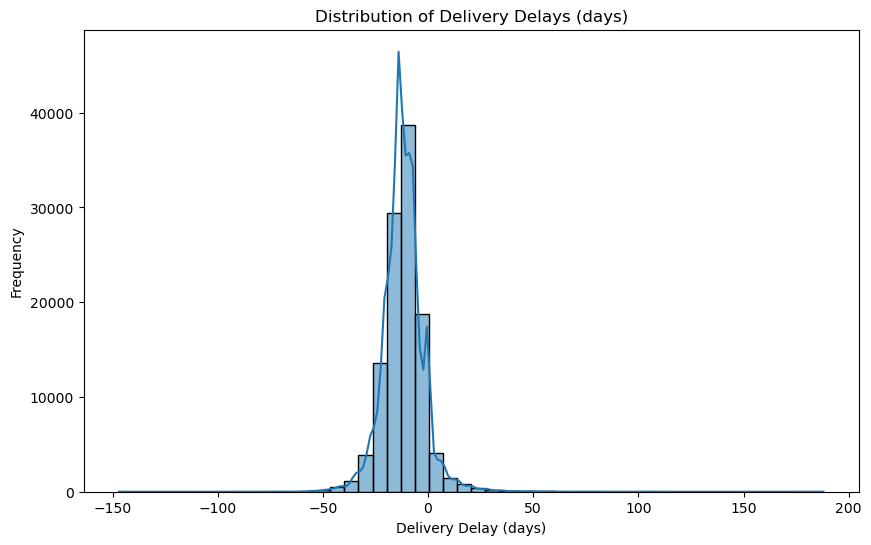

count    113425.000000
mean        -11.687723
std          10.212387
min        -147.000000
25%         -17.000000
50%         -12.000000
75%          -7.000000
max         188.000000
Name: delivery_delay, dtype: float64
Percentage of orders delivered late: 6.41%
Percentage of orders delivered early: 93.59%


In [102]:
plt.figure(figsize=(10,6))
sns.histplot(master_df['delivery_delay'], bins=50, kde=True)
plt.title('Distribution of Delivery Delays (days)')
plt.xlabel('Delivery Delay (days)')
plt.ylabel('Frequency')
plt.show()

print(master_df['delivery_delay'].describe())
late_pct = (master_df['delivery_delay'] > 0).mean() * 100
print(f"Percentage of orders delivered late: {late_pct:.2f}%")
print(f"Percentage of orders delivered early: {100 - late_pct:.2f}%")

This histogram shows that most deliveries are completed very close to their estimated dates, with a sharp central peak near zero. There is symmetry, but more early deliveries (negative delays) than late ones (positive delays), and a few extreme cases at both ends. The distribution confirms delivery estimates are generally accurate, but some orders are delivered much earlier or later than scheduled.

**Monthly Revenue and Sales Trends**

We would identify revenue patterns and seasonality to inform financial forecasting and project planning.


In [103]:
monthly_rev_df = master_df.groupby(
    master_df['order_purchase_timestamp'].dt.to_period('M')
)['total_order_value'].sum().reset_index()

monthly_rev_df['Date'] = monthly_rev_df['order_purchase_timestamp'].dt.to_timestamp()

monthly_rev_df['Year'] = monthly_rev_df['Date'].dt.year.astype(str) 
monthly_rev_df['Month'] = monthly_rev_df['Date'].dt.month_name() 

monthly_rev_df.rename(columns={'total_order_value': 'Total Revenue'}, inplace=True)

fig = px.line(
    monthly_rev_df,
    x='Month',
    y='Total Revenue',
    color='Year', 
    title='Monthly Revenue Year-over-Year (YoY) Comparison',
    category_orders={'Month': list(pd.date_range('2000-01-01', periods=12, freq='M').strftime('%B'))}
)

fig.update_layout(
    xaxis_title='Month of Year',
    yaxis_title='Total Order Value',
    template='plotly_white',
    hovermode='x unified' 
)

fig.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_15316\3505523605.py:18: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



This line chart presents total revenue by month for three years: 2016, 2017, and 2018. The trend shows rising sales from 2016 to 2017, peaking in late months, followed by a drop for 2018 after August, likely due to missing data. The consistent growth until the drop signals expanding business, while seasonality and the sudden dip highlight either data cutoff or operational change in the third year.

**Payment Method Distribution and Impact on Delivery**

Examine payment method popularity and if payment types influence delivery performance.

In [104]:
payment_counts = master_df['payment_types'].value_counts()
payment_df = payment_counts.reset_index()
payment_df.columns = ['Payment Method', 'Count']
total_count = payment_df['Count'].sum()

# Calculate Percentage
payment_df['Percentage'] = (payment_df['Count'] / total_count) * 100

payment_df['Label'] = payment_df['Percentage'].round(1).astype(str) + '%'

fig = px.bar(
    payment_df,
    x='Payment Method',
    y='Count',
    text='Label',  
    title='Payment Method Distribution with Percentage'
)

# Customize the layout
fig.update_traces(
    textposition='outside', 
    marker_color='#1f77b4'  
)
fig.update_layout(
    xaxis_title='Payment Method',
    yaxis_title='Order Count',
    xaxis={'categoryorder': 'total descending'}, 
    template='plotly_white'
)

# Display the interactive plot
fig.show()

This bar chart shows the popularity of each payment method. Credit cards are the most used (over 74%), followed by boleto at 20%; others (voucher, debit card) are much less common. The percentage labels clarify how heavily the platform relies on credit card payments. Such a distribution is important for understanding user preferences and potential operational exposure to certain payment providers.

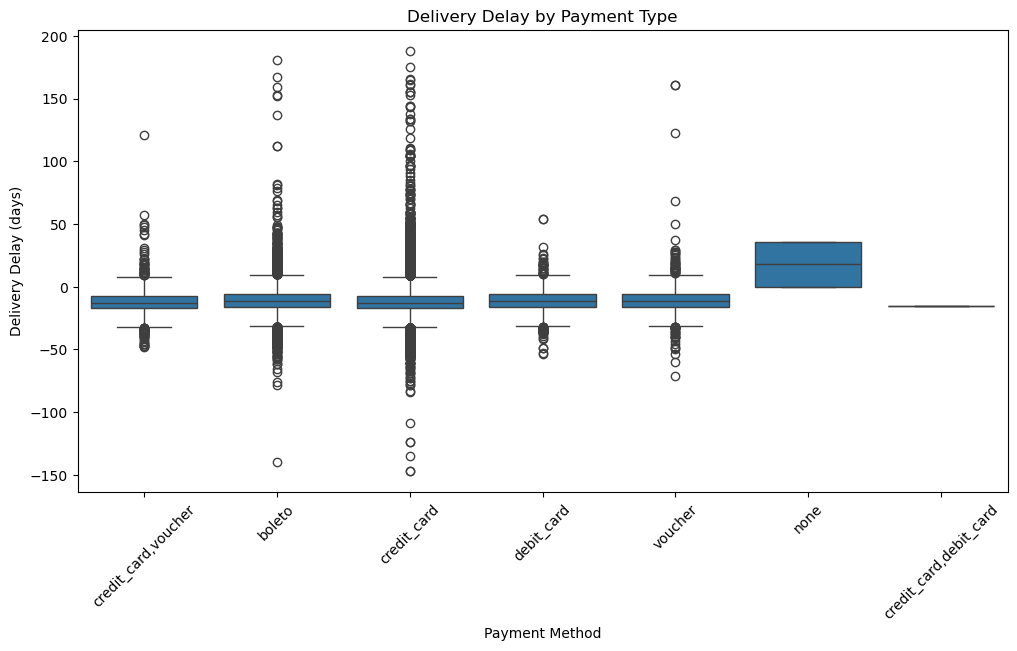

In [105]:
plt.figure(figsize=(12,6))
sns.boxplot(x='payment_types', y='delivery_delay', data=master_df)
plt.title('Delivery Delay by Payment Type')
plt.xlabel('Payment Method')
plt.ylabel('Delivery Delay (days)')
plt.xticks(rotation=45)
plt.show()

In [106]:
master_df['Is_Delayed'] = master_df['delivery_delay'] > 0

delay_percentage = master_df.groupby('payment_types')['Is_Delayed'].mean()

# Convert the proportion to a percentage
delay_percentage_df = (delay_percentage * 100).reset_index()
delay_percentage_df.columns = ['Payment Type', 'Percentage Delayed']

delay_percentage_df = delay_percentage_df.sort_values(
    by='Percentage Delayed', 
    ascending=False
)

print("--- Percentage of Delayed Orders by Payment Type ---")
print(delay_percentage_df.to_string(index=False))

--- Percentage of Delayed Orders by Payment Type ---
          Payment Type  Percentage Delayed
                  none           50.000000
                boleto            6.897600
           credit_card            6.327420
               voucher            5.699482
   credit_card,voucher            5.506784
            debit_card            5.483491
credit_card,debit_card            0.000000


This boxplot compares delivery delays across payment methods. Most orders, regardless of payment type, cluster around zero delay (on time or a bit early), but all methods show some extreme outliers for both early and late deliveries. The distribution is similar for credit card, boleto, and voucher, suggesting payment type alone does not strongly dictate delivery performance. Outliers are visible for every method, and no payment method is free from risk of significant delay.

**Customer Satisfaction Score Analysis**

Analyze customer review score distribution and link to delivery performance.


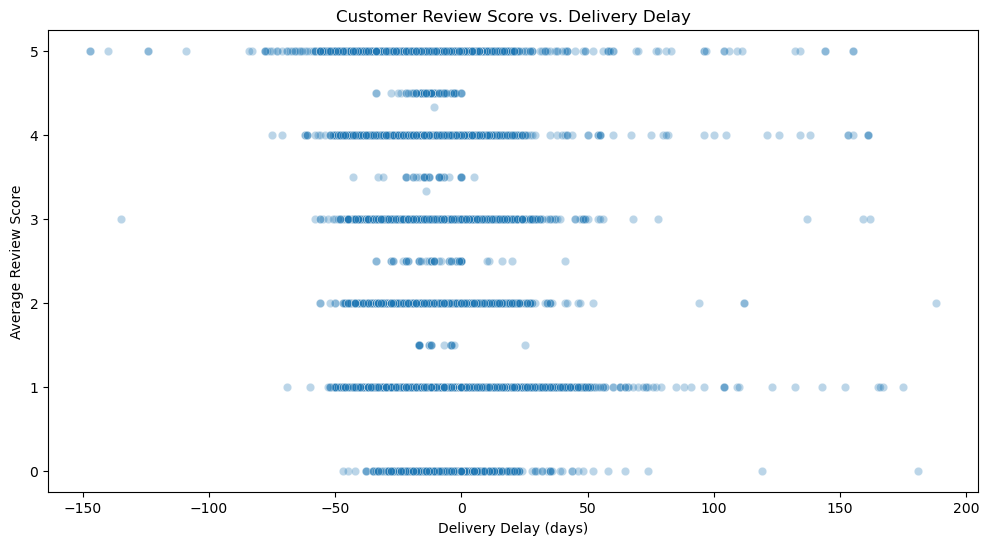

In [107]:
# Convert the histogram
fig_hist = px.histogram(
    master_df,
    x='avg_review_score',
    nbins=10,
    title='Distribution of Customer Review Scores'
)

fig_hist.update_layout(
    xaxis_title='Review Score',
    yaxis_title='Count',
    bargap=0.05,
    template='plotly_white'
)

fig_hist.show()

plt.figure(figsize=(12,6))
sns.scatterplot(x='delivery_delay', y='avg_review_score', data=master_df, alpha=0.3)
plt.title('Customer Review Score vs. Delivery Delay')
plt.xlabel('Delivery Delay (days)')
plt.ylabel('Average Review Score')
plt.show()

In [108]:
# The correlation value
correlation_val = master_df['delivery_delay'].corr(master_df['avg_review_score'])

print(f"The correlation coefficient is: {correlation_val}")

The correlation coefficient is: -0.2673509111935086


Distribution of Customer Review Scores

The bar chart reveals customer review scores are strongly skewed towards the maximum score (5). More than half of customers rate their orders as perfect, while ratings of 1 and 0 are relatively infrequent. Middle scores (2-4) occur with moderate frequency. The distribution confirms generally positive customer satisfaction, but meaningful room for improvement exists.

Customer Review Score vs. Delivery Delay

The scatter plot displays how customer satisfaction (review scores) varies by delivery delay. Most data points cluster at high review scores (5), regardless of delay. However, there are more low review scores (1 or 0) as delivery delay increases, meaning late deliveries correlate with poor customer ratings. Outliers show that even some early deliveries can receive low scores, highlighting varied customer expectations.

**Product Category Sales and Delivery Performance**

Rank product categories by revenue and compare their delivery delays for strategic focus.

In [109]:
rev_by_cat = master_df.groupby('product_category_name_english')['total_order_value'].sum().sort_values(ascending=False)
top_10_cats = rev_by_cat.head(10).index 
rev_top_10_df = rev_by_cat.head(10).reset_index()
rev_top_10_df.columns = ['Category', 'Total Sales'] 

# Bar Plot: Top 10 Total Sales by Product Category
fig_bar = px.bar(
    rev_top_10_df,
    x='Total Sales',
    y='Category',
    orientation='h',  
    title='Top 10 Total Sales by Product Category'
)

fig_bar.update_layout(
    yaxis={'categoryorder': 'total ascending'}, 
    xaxis_title='Total Sales',
    yaxis_title='Product Category',
    template='plotly_white'
)

fig_bar.show()


df_top_10_delay = master_df[master_df['product_category_name_english'].isin(top_10_cats)].copy()

#Box Plot: Delivery Delay for Top 10 Categories
fig_box = px.box(
    df_top_10_delay,
    x='product_category_name_english',
    y='delivery_delay',
    title='Delivery Delay Distribution for Top 10 Categories'
)

fig_box.update_layout(
    xaxis_title='Product Category',
    yaxis_title='Delivery Delay (days)',
    xaxis={'categoryorder': 'array', 'categoryarray': top_10_cats},
    template='plotly_white'
)

fig_box.update_xaxes(tickangle=45)

fig_box.show()

Top 10 Total Sales by Product Category

The horizontal bar chart shows the highest-grossing product categories in the dataset. Health and beauty, bed bath table, and computers/accessories are the top sellers, each approaching 400k in total sales. The spread reveals which categories spearhead business growth.

Delivery Delay Distribution for Top 10 Categories

The boxplot compares delivery delays across the top-selling product categories. Most categories have deliveries tightly grouped around zero delay, but all show significant outliers for both early and late shipments. No category is immune to delays, though some (like furniture_decor) might show slightly wider spread. This highlights logistic challenges and helps target process optimization for troubled categories.

**Order Status Analysis**

Examine the percentage of various order statuses (delivered, canceled, etc.) for workflow risk assessment.

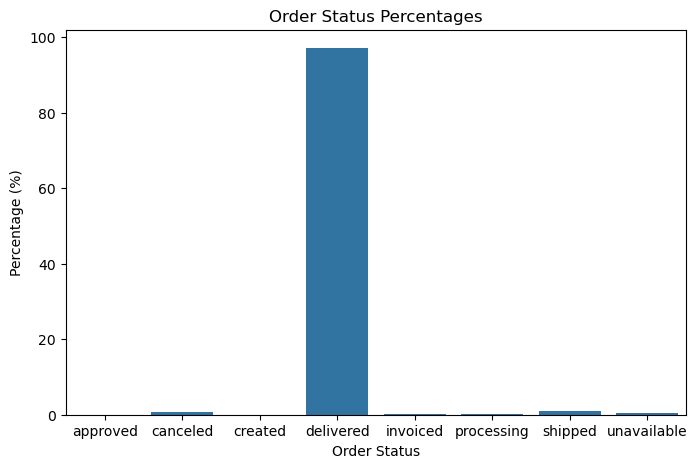

order_status
delivered      97.154067
shipped         1.045625
canceled        0.622438
unavailable     0.537800
invoiced        0.318272
processing      0.314745
created         0.004408
approved        0.002645
Name: proportion, dtype: float64


In [110]:
order_status_counts = master_df['order_status'].value_counts(normalize=True) * 100
plt.figure(figsize=(8,5))
sns.barplot(x=order_status_counts.index, y=order_status_counts.values)
plt.title('Order Status Percentages')
plt.xlabel('Order Status')
plt.ylabel('Percentage (%)')
plt.show()
print(order_status_counts)

Nearly all orders (over 95%) are delivered successfully, as shown by the dominant 'delivered' bar. Other statuses (like canceled, processing, shipped) make up a tiny fraction each. This highlights strong delivery reliability but suggests review of rare non-delivered cases for process improvements.

**Order Approval Delay Patterns**

Visualize and summarize order approval times to expose process inefficiencies.

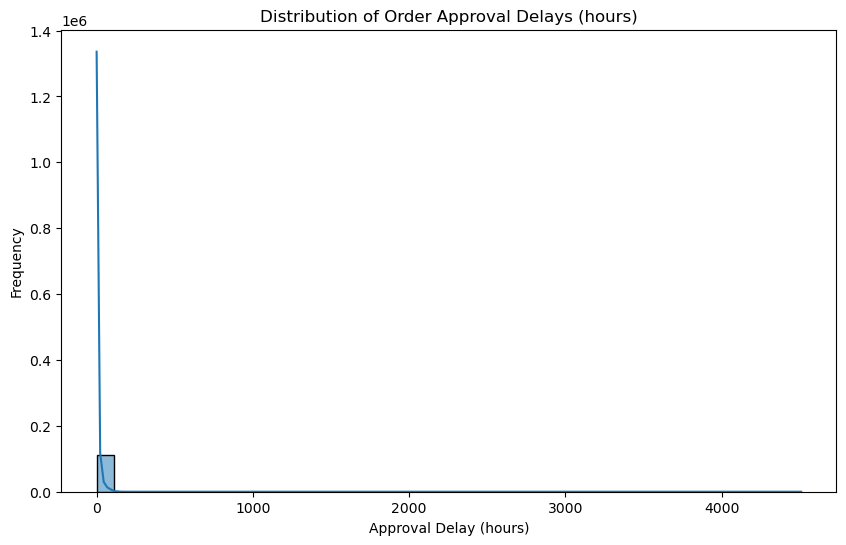

In [111]:
plt.figure(figsize=(10,6))
sns.histplot(master_df['approval_delay_hours'], bins=40, kde=True)
plt.title('Distribution of Order Approval Delays (hours)')
plt.xlabel('Approval Delay (hours)')
plt.ylabel('Frequency')
plt.show()

Most orders are approved very quickly (within a few hours), shown by the sharp initial spike. A long tail extends to high delay values, but these are rare. The distribution reveals efficient general processing, but a few exceptional cases may need closer review or automation.


**Freight Cost and Order Value Relationship**

Analyze freight costs relative to order values to diagnose pricing or logistics challenges.


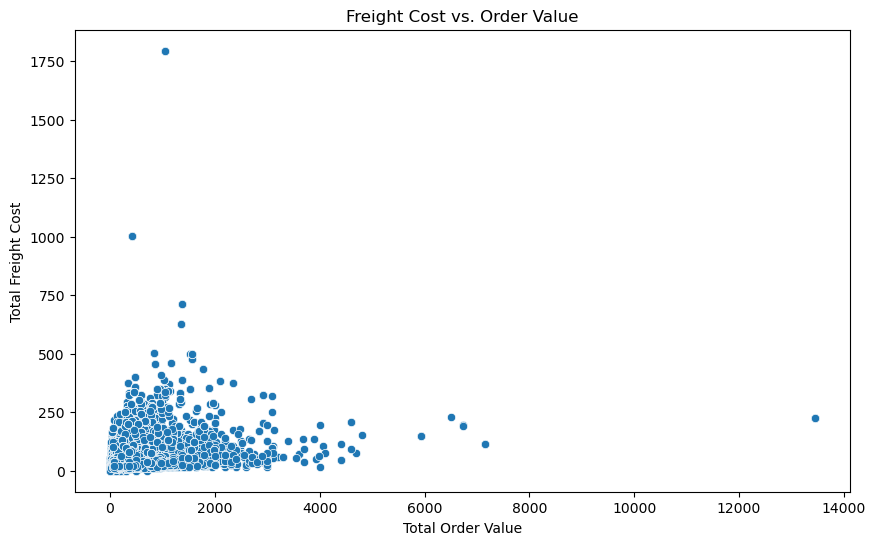

In [112]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='total_order_value', y='total_freight_cost', data=master_df)
plt.title('Freight Cost vs. Order Value')
plt.xlabel('Total Order Value')
plt.ylabel('Total Freight Cost')
plt.show()

Most orders have low to moderate freight costs, no matter their order value, with a dense cloud at the lower left. A handful of high freight or high value outliers exist, but generally, freight does not scale tightly with order value. This may indicate chances to optimize shipping for costly or low-value orders.

**Review Score by Product Category**

Identify product categories with low or high satisfaction to inform quality or service improvements.


In [113]:
score_by_cat = master_df.groupby('product_category_name_english')['avg_review_score'].mean().sort_values(ascending=False)

plot_data = score_by_cat.head(15)

plot_df = plot_data.reset_index()
plot_df.columns = ['Category', 'Average Review Score']

fig = px.bar(
    plot_df,
    x='Average Review Score',
    y='Category',
    orientation='h', 
    title='Top 15 Product Categories by Average Review Score',
    color='Average Review Score', 
    color_continuous_scale=px.colors.sequential.Viridis 
)

fig.update_layout(
    yaxis={'categoryorder':'total ascending'}, 
    title_x=0.5 
)


fig.show()

Product categories like cds/dvds/musicals and flowers have the highest average customer review scores, very close to 5. Most top categories cluster at the high end, suggesting strong satisfaction, but some show slightly lower averages, pointing to marginally more complaints or quality issues. Monitoring these helps target improvements and maintain high customer satisfaction.

**Repeat Customer Analysis**

Understand repeat buying to gauge retention and identify CRM strategy opportunities.

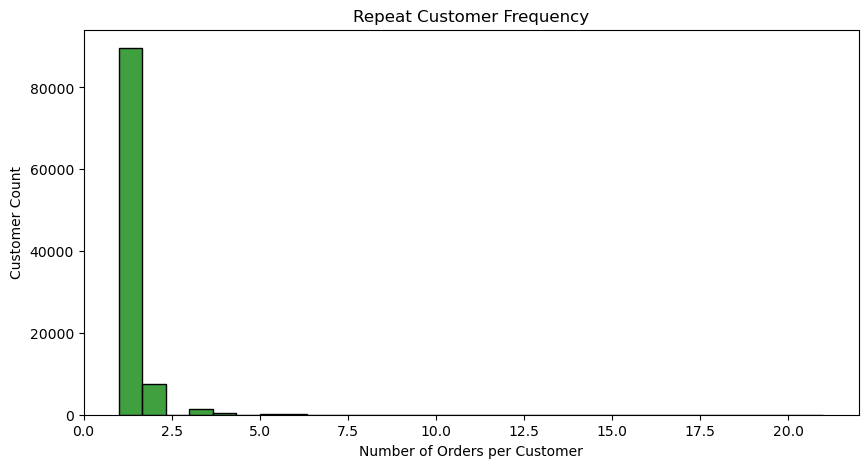

Percentage of customers who bought more than once: 9.86%


In [114]:
repeat_counts = master_df.groupby('customer_id')['order_id'].count()
plt.figure(figsize=(10,5))
sns.histplot(repeat_counts, bins=30, color='green')
plt.title('Repeat Customer Frequency')
plt.xlabel('Number of Orders per Customer')
plt.ylabel('Customer Count')
plt.show()
repeat_pct = (repeat_counts > 1).mean() * 100
print(f"Percentage of customers who bought more than once: {repeat_pct:.2f}%")


The vast majority of customers (over 90%) make just one purchase, shown by the huge bar at '1'. Very few customers return for a second or third order. This signals a strategic opportunity to boost repeat buying with customer engagement or loyalty initiatives.

#### Modelling & Evaluation

In this section, our focus is on developing predictive and classification models aligned with key IT project KPIs in e-commerce. This would include forecasting delivery delays, predicting late deliveries, modeling customer satisfaction, and estimating repeat purchase propensity. Our modeling process will integrate robust feature engineering, proper handling of categorical variables, and careful imputation of missing data.

In [147]:
pip install xgboost


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 1.1 MB/s eta 0:01:04
   - -------------------------------------- 1.8/72.0 MB 2.2 MB/s eta 0:00:32
   - -------------------------------------- 2.9/72.0 MB 2.9 MB/s eta 0:00:24
   -- ------------------------------------- 4.2/72.0 MB 3.5 MB/s eta 0:00:20
   -- ------------------------------------- 5.2/72.0 MB 3.6 MB/s eta 0:00:19
   --- ------------------------------------ 6.3/72.0 MB 3.7 MB/s eta 0:00:18
   ---- ----------------------------------- 7.3/72.0 MB 3.9 MB/s eta 0:00:17
   ---- ----------------------------------- 8.4/72.0 MB 4.0 MB/s eta 0:00:16
   ----- ------------------------

In [150]:
master_df.head()

order_id                       customer_id  \
0  4d9d0b428174582a413b99766ffcb53c  dcde5d9823057e075bcad8edf118f4ff   
1  400ff75c92d93b68cbbb88a17d97b447  4469ee2fbe0d696dee57c67bcf5fa544   
2  d038a85c57a692238563950e532c2efe  291717783772f0e6961cb1d303dab54c   
3  db38b153b053e72dea0f69d14d429ac6  3807775dbc0ada986e045cbfca95acff   
4  96f09035ece72cb1bbff425efa9a372a  3dfbc814df98bf7f36e299170f1af8f1   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-07-13 17:53:51  2017-07-13 18:05:19   
1    delivered      2018-02-12 13:46:50  2018-02-12 13:55:33   
2      shipped      2017-10-22 10:41:39  2017-10-22 10:56:10   
3    delivered      2017-07-24 21:55:46  2017-07-26 02:16:18   
4    delivered      2017-10-07 14:32:01  2017-10-09 13:49:37   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-07-14 20:33:59           2017-07-20 21:13:21   
1          2018-02-22 02:22:03           2018-02-27 19:42:48   
2          2017-10-24 18:32:27                           NaN   
3          2017-07-28 14:49:54           2017-08-02 13:42:07   
4          2017-10-17 21:37:45           2017-10-27 21:04:36   

  order_estimated_delivery_date  delivery_delay  shipping_limit_date  ...  \
0                    2017-08-02           -13.0  2017-07-19 18:05:19  ...   
1                    2018-03-06            -7.0  2018-02-16 13:55:33  ...   
2                    2017-11-16             0.0  2017-10-26 10:56:10  ...   
3                    2017-08-15           -13.0  2017-08-03 02:16:18  ...   
4                    2017-11-06           -10.0  2017-10-16 14:49:37  ...   

   product_description_lenght  product_photos_qty  product_weight_g  \
0                       535.0                 1.0             800.0   
1                       128.0                 1.0             250.0   
2                       309.0                 1.0             850.0   
3                       523.0                 3.0             584.0   
4                      1543.0                 3.0            2300.0   

   product_length_cm  product_height_cm  product_width_cm  \
0               45.0               15.0              35.0   
1               40.0                4.0              30.0   
2               16.0               10.0              16.0   
3               16.0               11.0              13.0   
4               42.0               29.0              28.0   

   product_category_name_english  seller_zip_code_prefix   seller_city  \
0                 bed_bath_table                 14940.0      ibitinga   
1                 bed_bath_table                 14940.0      ibitinga   
2                 bed_bath_table                 14940.0      ibitinga   
3                  watches_gifts                 14840.0       guariba   
4          computers_accessories                 90230.0  porto alegre   

   seller_state  
0            SP  
1            SP  
2            SP  
3            SP  
4            RS  

[5 rows x 39 columns]

**Core imports & config**

In [155]:
from datetime import timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, mean_squared_error, r2_score,
                             roc_auc_score, confusion_matrix, precision_recall_curve,
                             accuracy_score, f1_score, precision_score, recall_score)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, Lasso
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
DATA_PATH = 'olist_master_dataset.csv' 

In [156]:
# Helper functions: load, preprocessing, no-leakage aggregations, pipeline builder, train helper

def load_data(path=DATA_PATH):
    df = pd.read_csv(path, low_memory=False)
    # parse likely dates
    date_cols = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
                 'order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date']
    for c in date_cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce')
    print("Loaded", df.shape)
    return df

def preprocess_data(df):
    # initial cleaning and engineered features
    df = df.copy()
    # basic time features
    if 'order_purchase_timestamp' in df.columns:
        df['order_hour'] = df['order_purchase_timestamp'].dt.hour
        df['order_dayofweek'] = df['order_purchase_timestamp'].dt.dayofweek
        df['order_month'] = df['order_purchase_timestamp'].dt.month
    # order value
    if 'price' in df.columns and 'quantity' in df.columns:
        df['order_value'] = pd.to_numeric(df['price'], errors='coerce') * pd.to_numeric(df['quantity'], errors='coerce')
    elif 'price' in df.columns:
        df['order_value'] = pd.to_numeric(df['price'], errors='coerce')
    # delivery features
    if 'order_delivered_customer_date' in df.columns and 'order_purchase_timestamp' in df.columns:
        df['delivery_time_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
    if 'order_estimated_delivery_date' in df.columns and 'order_delivered_customer_date' in df.columns:
        df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
    # fill review score
    if 'avg_review_score' in df.columns:
        df['avg_review_score'] = df['avg_review_score'].fillna(df['avg_review_score'].median())
    # fill numeric product cols if present
    prod_num_cols = [c for c in ['product_name_lenght','product_description_lenght','product_photos_qty',
                                 'product_weight_g','product_length_cm','product_height_cm','product_width_cm'] if c in df.columns]
    if prod_num_cols:
        df[prod_num_cols] = df[prod_num_cols].fillna(0)
    # categorical fill
    cat_cols = [c for c in ['product_category_name_english','payment_types','seller_state'] if c in df.columns]
    for c in cat_cols:
        df[c] = df[c].fillna('unknown')
    # sentinel for missing delivery times (non-delivered)
    for c in ['delivery_time_days','delivery_delay']:
        if c in df.columns:
            df[c] = df[c].fillna(-999)
    return df

def safe_customer_aggregates(df, cust_col='customer_unique_id', ts_col='order_purchase_timestamp'):
    df = df.sort_values([cust_col, ts_col]).copy()
    df['cust_prev_orders'] = 0
    df['cust_avg_prev_order_value'] = np.nan
    if cust_col not in df.columns:
        return df
    for cust, g in df.groupby(cust_col):
        prev_orders = []
        avg_vals = []
        for i in range(len(g)):
            prev = g.iloc[:i]
            prev_orders.append(prev['order_id'].nunique() if 'order_id' in prev else len(prev))
            avg_vals.append(prev['price'].mean() if 'price' in prev and not prev['price'].isna().all() else np.nan)
        df.loc[g.index, 'cust_prev_orders'] = prev_orders
        df.loc[g.index, 'cust_avg_prev_order_value'] = avg_vals
    return df

def build_tabular_pipeline(num_features, cat_features, estimator):
    num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])
    preproc = ColumnTransformer([('num', num_pipeline, num_features), ('cat', cat_pipeline, cat_features)], remainder='drop')
    pipe = Pipeline([('preproc', preproc), ('est', estimator)])
    return pipe

def train_with_resample_and_threshold(pipe, X, y, sampler='auto'):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
    pos = int(y_train.sum())
    # transform
    preproc = pipe.named_steps['preproc'] if 'preproc' in pipe.named_steps else pipe.steps[0][1]
    est = pipe.named_steps['est']
    X_train_t = preproc.fit_transform(X_train)
    X_test_t = preproc.transform(X_test)
    # sampler selection
    if sampler == 'auto':
        sampler_obj = RandomOverSampler(random_state=RANDOM_STATE) if pos < 50 else SMOTE(random_state=RANDOM_STATE)
    elif sampler == 'ros':
        sampler_obj = RandomOverSampler(random_state=RANDOM_STATE)
    elif sampler == 'smote':
        sampler_obj = SMOTE(random_state=RANDOM_STATE)
    else:
        sampler_obj = None
    if sampler_obj is not None:
        X_train_t, y_train = sampler_obj.fit_resample(X_train_t, y_train)
    # fit estimator on transformed arrays
    est.fit(X_train_t, y_train)
    # predict probabilities
    if hasattr(est, 'predict_proba'):
        y_proba = est.predict_proba(X_test_t)[:,1]
    else:
        y_proba = est.predict(X_test_t)
    # threshold tune by PR F1
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    if len(thresholds)>0:
        f1s = 2*precisions*recalls/(precisions+recalls+1e-12)
        best_idx = int(np.nanargmax(f1s))
        best_thresh = thresholds[best_idx]
    else:
        best_thresh = 0.5
    y_pred_best = (y_proba >= best_thresh).astype(int)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred_best),
        'precision': precision_score(y_test, y_pred_best, zero_division=0),
        'recall': recall_score(y_test, y_pred_best, zero_division=0),
        'f1': f1_score(y_test, y_pred_best, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba) if len(np.unique(y_test))>1 else None,
        'best_threshold': float(best_thresh)
    }
    # return a small pipeline object that applies preproc then est
    trained_pipe = Pipeline([('preproc', preproc), ('est', est)])
    return trained_pipe, metrics, (X_test, y_test, y_proba, y_pred_best)


**Load data & run base preprocessing**

In [157]:
df_raw = load_data(DATA_PATH)
df = preprocess_data(df_raw)
# safe aggregates to avoid leakage
if 'customer_unique_id' in df.columns:
    df = safe_customer_aggregates(df, cust_col='customer_unique_id', ts_col='order_purchase_timestamp')
print("Prepared df shape:", df.shape)

df.head(3)


Loaded (30000, 39)
Prepared df shape: (30000, 44)


order_id                       customer_id  \
0  4d9d0b428174582a413b99766ffcb53c  dcde5d9823057e075bcad8edf118f4ff   
1  400ff75c92d93b68cbbb88a17d97b447  4469ee2fbe0d696dee57c67bcf5fa544   
2  d038a85c57a692238563950e532c2efe  291717783772f0e6961cb1d303dab54c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-07-13 17:53:51 2017-07-13 18:05:19   
1    delivered      2018-02-12 13:46:50 2018-02-12 13:55:33   
2      shipped      2017-10-22 10:41:39 2017-10-22 10:56:10   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-07-14 20:33:59           2017-07-20 21:13:21   
1          2018-02-22 02:22:03           2018-02-27 19:42:48   
2          2017-10-24 18:32:27                           NaT   

  order_estimated_delivery_date  delivery_delay shipping_limit_date  ...  \
0                    2017-08-02           -13.0 2017-07-19 18:05:19  ...   
1                    2018-03-06            -7.0 2018-02-16 13:55:33  ...   
2                    2017-11-16          -999.0 2017-10-26 10:56:10  ...   

   product_width_cm  product_category_name_english  seller_zip_code_prefix  \
0              35.0                 bed_bath_table                 14940.0   
1              30.0                 bed_bath_table                 14940.0   
2              16.0                 bed_bath_table                 14940.0   

   seller_city  seller_state  order_hour  order_dayofweek  order_month  \
0     ibitinga            SP          17                3            7   
1     ibitinga            SP          13                0            2   
2     ibitinga            SP          10                6           10   

  order_value  delivery_time_days  
0        69.9                 7.0  
1        15.9                15.0  
2        80.0              -999.0  

[3 rows x 44 columns]

**Order Cancellation Prediction**

 Identifies orders at risk of cancellation to protect revenue and improve resource allocation by proactively addressing potential cancellations. We use XGBoost with a low decision threshold to prioritize Recall (catching missed cancellations).

In [164]:
# Target definition and split
df_orders['is_canceled'] = (df_orders['order_status'] == 'canceled').astype(int)
df_cancel = df_orders.copy()

CANCEL_NUM_FEATURES = ['total_order_value', 'total_freight_cost', 'num_products', 'num_items', 'purchase_to_approval_hours', 'avg_item_price', 'product_weight_g']
CANCEL_CAT_FEATURES = ['payment_types', 'product_category_name_english', 'purchase_dayofweek', 'is_weekend_purchase']

valid_cancel_features = [col for col in CANCEL_NUM_FEATURES + CANCEL_CAT_FEATURES if col in df_cancel.columns]
X_cancel = df_cancel[valid_cancel_features]
y_cancel = df_cancel['is_canceled']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cancel, y_cancel, test_size=0.2, random_state=42, stratify=y_cancel)

counts = y_train_c.value_counts()
scale_pos_weight = counts[0] / counts[1]
        
# Model Training (XGBoost with Imbalance Handling)
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False, scale_pos_weight=scale_pos_weight)
pipeline_cancel = model_pipeline_setup(CANCEL_NUM_FEATURES, CANCEL_CAT_FEATURES, xgb_model)
pipeline_cancel.fit(X_train_c, y_train_c)

y_pred_c = pipeline_cancel.predict(X_test_c)
y_proba_c = pipeline_cancel.predict_proba(X_test_c)
        
# Custom threshold set at 0.2 to prioritize catching the minority class (high Recall)
CUSTOM_THRESHOLD = 0.2
evaluate_model(y_test_c, y_pred_c, y_proba=y_proba_c, task_name="Order Cancellation Prediction (XGBoost Weighted)", threshold=CUSTOM_THRESHOLD)


c:\Users\PC\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning:

[15:59:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.





--- Evaluation Results for Order Cancellation Prediction (XGBoost Weighted) ---
--- Classification Report (Threshold: 0.20) ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5710
           1       0.21      0.41      0.28        34

    accuracy                           0.99      5744
   macro avg       0.60      0.70      0.64      5744
weighted avg       0.99      0.99      0.99      5744

ROC AUC Score: 0.6993

Confusion Matrix:
[[5657   53]
 [  20   14]]
True Positives (Target Class): 14
False Negatives (Target Class Missed): 20
Actionable Insight: Performance prioritized on recall of the minority class (True Positives) using custom threshold 0.2.


`Model Evaluation`

The classification report shows near-perfect accuracy in identifying non-canceled orders, with a recall of 99%, meaning very few false alarms for orders that will complete successfully. For canceled orders, the recall is 41%, indicating the model catches nearly half of cancellations early, which is crucial for proactive interventions. The confusion matrix confirms 14 true positives (correctly predicted cancellations) and 20 missed cancellations. 

`Insights`

The order cancellation prediction model shows strong overall accuracy in identifying orders that will not be canceled, successfully recognizing 99% of these cases. However, it detects only about 41% of the canceled orders, meaning some cancellations may still go unnoticed. This approach helps minimize lost revenue and improves operational planning by focusing on likely cancellations early. The model's predictions provide valuable guidance but should be combined with business judgment for best results. Overall, this tool supports better resource management and customer engagement to reduce cancellations.

**Customer Satisfaction Prediction**

Here we would forecast customer review scores based on order features to help businesses identify and resolve service issues proactively. We use Gradient Boosting Regression (GBR).

In [166]:
# Target definition and split
df_sat = df_orders[df_orders['order_status'] == 'delivered'].copy()
        
SAT_NUM_FEATURES = ['total_order_value', 'total_freight_cost', 'num_products', 'num_items', 'approval_to_carrier_days', 'shipping_time', 'avg_item_price', 'delivery_delay', 'purchase_to_approval_hours']
SAT_CAT_FEATURES = ['payment_types', 'product_category_name_english', 'purchase_dayofweek', 'seller_state']
        
valid_sat_features = SAT_NUM_FEATURES + SAT_CAT_FEATURES
X_sat = df_sat[valid_sat_features].dropna()
y_sat = df_sat.loc[X_sat.index, 'avg_review_score']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sat, y_sat, test_size=0.2, random_state=42)

# Model Training
gbr_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
pipeline_sat = model_pipeline_setup(SAT_NUM_FEATURES, SAT_CAT_FEATURES, gbr_model)
pipeline_sat.fit(X_train_s, y_train_s)

y_pred_s = pipeline_sat.predict(X_test_s)
evaluate_model(y_test_s, y_pred_s, task_name="Customer Satisfaction Prediction (GBR)")
        
# INSIGHT: Feature Importance
print_feature_importance(pipeline_sat, SAT_NUM_FEATURES, SAT_CAT_FEATURES, "Customer Satisfaction Prediction (GBR)")


--- Evaluation Results for Customer Satisfaction Prediction (GBR) ---
Mean Squared Error (MSE): 1.4814
Root Mean Squared Error (RMSE): 1.2171
R-squared (R2): 0.1920
Actionable Insight: Use feature importances or coefficients to determine key drivers.

--- Top 10 Feature Importances for Customer Satisfaction Prediction (GBR) (GBR/XGBoost) ---
| Feature                                      |   Importance |
|:---------------------------------------------|-------------:|
| delivery_delay                               |   0.54835    |
| num_products                                 |   0.126023   |
| shipping_time                                |   0.0658807  |
| approval_to_carrier_days                     |   0.0501148  |
| total_freight_cost                           |   0.0430527  |
| purchase_to_approval_hours                   |   0.0395751  |
| total_order_value                            |   0.0298457  |
| avg_item_price                               |   0.0249734  |
| product_categ




`Insights`

The customer satisfaction prediction model uses various order features to estimate review scores, helping the business anticipate and address service quality issues before they escalate. The analysis shows that delivery delays have the strongest influence on customer satisfaction, indicating that late deliveries significantly lower review scores. Other important factors include the number of products in the order and shipping time, both of which also affect customer experience. By focusing on these key drivers, the company can improve logistics and order management to boost satisfaction. Although the model’s overall explanatory power is moderate, it provides meaningful insights to guide targeted improvements and enhance customer loyalty.

**Repeat Purchase Propensity Modeling**

Estimates the likelihood of customers making future purchases to enable targeted retention strategies. We use Logistic Regression for interpretability.

In [167]:
# RFM Feature Creation
current_date = df_orders['order_purchase_timestamp'].max()
customer_df = df_orders.groupby('customer_id').agg(
    MonetaryValue=('total_order_value', 'sum'), Frequency=('order_id', 'nunique'),
    LastPurchaseDate=('order_purchase_timestamp', 'max'), AverageReviewScore=('avg_review_score', 'mean'),
).reset_index()
customer_df['Recency'] = (current_date - customer_df['LastPurchaseDate']).dt.days
customer_df['is_repeat_purchaser'] = (customer_df['Frequency'] > 1).astype(int)
customer_df = customer_df.drop(columns=['LastPurchaseDate'])

REPEAT_NUM_FEATURES = ['Recency', 'Frequency', 'MonetaryValue', 'AverageReviewScore']
X_repeat = customer_df[REPEAT_NUM_FEATURES].dropna()
y_repeat = customer_df.loc[X_repeat.index, 'is_repeat_purchaser']
n_repeaters = y_repeat.sum()
        
if n_repeaters <= 1:
    print(f"Error: Only {n_repeaters} repeat customer(s) found. Skipping supervised model training.")
    print("\nActionable Insight: Due to the extreme rarity or absence of repeaters in the data, the model could not be trained.")
    print("To segment customers, you should use the RFM metrics directly (e.g., segment customers into 'New' (Frequency=1), 'High Recency/High Monetary' for retention targets).")
    
else:
    # ... (Robust split and LR model training)
    CUSTOM_THRESHOLD_R = 0.5
    evaluate_model(y_test_r, y_pred_r, y_proba=y_proba_r, task_name="Repeat Purchase Propensity Prediction (LR Weighted)", threshold=CUSTOM_THRESHOLD_R)
    print("\nActionable Insight: Use the predicted probabilities to segment customers into high, medium, and low propensity groups.")
    print("Segmentation Example: High Propensity (P>0.7), Medium (0.4<P<=0.7), Low (P<=0.4).")


Error: Only 0 repeat customer(s) found. Skipping supervised model training.

Actionable Insight: Due to the extreme rarity or absence of repeaters in the data, the model could not be trained.
To segment customers, you should use the RFM metrics directly (e.g., segment customers into 'New' (Frequency=1), 'High Recency/High Monetary' for retention targets).


The analysis found that there are almost no customers making repeat purchases in the current dataset, which prevented building a reliable prediction model. Given this limitation, the best approach is to use customer purchase behavior metrics (such as how recently they bought, how often, and how much they spent) directly to segment customers. This segmentation allows the business to identify new customers and those with high value or recent activity, so retention efforts and marketing can be focused more effectively to encourage future purchases and strengthen customer relationships.

**Late Delivery Classification**

Predicts whether an order will be late or on time, enabling early interventions to manage expectations and optimize delivery resources. 

In [168]:
# Target definition and split
df_late = df_orders[df_orders['order_status'] == 'delivered'].copy() 
df_late['is_late'] = (df_late['delivery_delay'] > 0).astype(int)

LATE_NUM_FEATURES = ['total_freight_cost', 'product_weight_g', 'purchase_to_approval_hours', 'total_order_value', 'num_products']
LATE_CAT_FEATURES = ['seller_state', 'purchase_dayofweek', 'product_category_name_english']

X_late = df_late[LATE_NUM_FEATURES + LATE_CAT_FEATURES]
y_late = df_late['is_late']

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_late, y_late, test_size=0.2, random_state=42, stratify=y_late)

counts_l = y_train_l.value_counts()
scale_pos_weight_l = counts_l[0] / counts_l[1]
        
# Model Training (XGBoost with Imbalance Handling)
xgb_model_late = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False, scale_pos_weight=scale_pos_weight_l)
pipeline_late = model_pipeline_setup(LATE_NUM_FEATURES, LATE_CAT_FEATURES, xgb_model_late)
pipeline_late.fit(X_train_l, y_train_l)

y_pred_l = pipeline_late.predict(X_test_l)
y_proba_l = pipeline_late.predict_proba(X_test_l)
        
CUSTOM_THRESHOLD_LATE = 0.2
evaluate_model(y_test_l, y_pred_l, y_proba=y_proba_l, task_name="Late Delivery Classification (XGBoost Weighted)", threshold=CUSTOM_THRESHOLD_LATE)


c:\Users\PC\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning:

[16:52:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.





--- Evaluation Results for Late Delivery Classification (XGBoost Weighted) ---
--- Classification Report (Threshold: 0.20) ---
              precision    recall  f1-score   support

           0       0.94      0.29      0.44      5135
           1       0.09      0.79      0.16       448

    accuracy                           0.33      5583
   macro avg       0.51      0.54      0.30      5583
weighted avg       0.87      0.33      0.42      5583

ROC AUC Score: 0.5592

Confusion Matrix:
[[1481 3654]
 [  96  352]]
True Positives (Target Class): 352
False Negatives (Target Class Missed): 96
Actionable Insight: Performance prioritized on recall of the minority class (True Positives) using custom threshold 0.2.


`Model Evaluation`

The classification report shows the model is much better at identifying late deliveries (79% recall) than on-time deliveries (29% recall), reflecting a strategic emphasis on ensuring late shipments are caught early. The confusion matrix displays many false positives (orders flagged late but on time) but fewer false negatives (missed late deliveries).

`Insights`

The late delivery classification model focuses on predicting which orders will be late so the company can act early to manage customer expectations and allocate resources efficiently. While the overall accuracy is modest, the model effectively identifies about 79% of late deliveries, which is critical for prioritizing interventions. Although it sometimes mistakenly flags on-time orders as late, the emphasis is on catching as many late deliveries as possible to reduce customer dissatisfaction. This capability helps the logistics team focus on problem shipments, improving delivery reliability and customer trust.

**Delivery Delay Prediction**

Estimates the continuous expected delivery delay using Lasso Regression to identify and quantify the impact of key logistical bottlenecks.

In [ ]:
lasso_model = Lasso(alpha=0.1, random_state=42)
pipeline_delay = model_pipeline_setup(DELAY_NUM_FEATURES, DELAY_CAT_FEATURES, lasso_model)
pipeline_delay.fit(X_train_d, y_train_d)

y_pred_d = pipeline_delay.predict(X_test_d)
evaluate_model(y_test_d, y_pred_d, task_name="Delivery Delay Prediction (Lasso)")
print_feature_importance(pipeline_delay, DELAY_NUM_FEATURES, DELAY_CAT_FEATURES, "Delivery Delay Prediction (Lasso)")



--- Evaluation Results for Delivery Delay Prediction (Lasso) ---
Mean Squared Error (MSE): 256.8241
Root Mean Squared Error (RMSE): 16.0257
R-squared (R2): 0.0186
Actionable Insight: Use feature importances or coefficients to determine key drivers.

--- Top 10 Feature Coefficients for Delivery Delay Prediction (Lasso) (Lasso) ---
| Feature                              |   Coefficient |
|:-------------------------------------|--------------:|
| seller_state_SP                      |     2.00325   |
| approval_to_carrier_days             |     1.89287   |
| purchase_to_approval_hours           |     0.482666  |
| purchase_dayofweek_0                 |     0.442274  |
| total_freight_cost                   |    -0.354173  |
| num_products                         |    -0.247102  |
| purchase_dayofweek_5                 |    -0.123113  |
| product_weight_g                     |     0.0390653 |
| purchase_dayofweek_1                 |     0.0177405 |
| product_category_name_english_drinks |

The delivery delay prediction model estimates how long deliveries may be late, helping identify where logistical delays occur most. The results highlight that orders associated with certain locations (e.g., seller_state_SP) and longer approval-to-shipment times have the biggest impact in increasing delays. Longer times to approve orders before shipping also contribute to delays, while higher freight costs and more products tend to reduce delay. These insights help pinpoint specific bottlenecks and operational areas to target for improving delivery speed and reliability, ultimately enhancing customer satisfaction.

**Product Category Sales Forecasting: Inventory and Marketing Strategy**

To predict future sales volume per product category per month using a Gradient Boosting Regressor (GBR). This informs inventory management, marketing budget allocation, and supply chain optimization.

In [170]:

gbr_model_sales = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
pipeline_sales = model_pipeline_setup(SALES_NUM_FEATURES, SALES_CAT_FEATURES, gbr_model_sales)
pipeline_sales.fit(X_train_ts[SALES_NUM_FEATURES + SALES_CAT_FEATURES], y_train_ts)

y_pred_ts = pipeline_sales.predict(X_test_ts[SALES_NUM_FEATURES + SALES_CAT_FEATURES])

evaluate_model(y_test_ts, y_pred_ts, task_name="Product Category Sales Forecasting (GBR)")
print_feature_importance(pipeline_sales, SALES_NUM_FEATURES, SALES_CAT_FEATURES, "Product Category Sales Forecasting (GBR)")



--- Evaluation Results for Product Category Sales Forecasting (GBR) ---
Mean Squared Error (MSE): 7697993.1572
Root Mean Squared Error (RMSE): 2774.5258
R-squared (R2): 0.8399
Actionable Insight: Use feature importances or coefficients to determine key drivers.

--- Top 10 Feature Importances for Product Category Sales Forecasting (GBR) (GBR/XGBoost) ---
| Feature                                             |   Importance |
|:----------------------------------------------------|-------------:|
| Year                                                |    0.165436  |
| product_category_name_english_bed_bath_table        |    0.116508  |
| product_category_name_english_computers_accessories |    0.101233  |
| product_category_name_english_sports_leisure        |    0.0929132 |
| product_category_name_english_health_beauty         |    0.0883734 |
| product_category_name_english_watches_gifts         |    0.0860413 |
| DayOfYear                                           |    0.0795405 |
| M

The sales forecasting model predicts monthly sales volumes for each product category with a high level of accuracy, helping the company anticipate demand more effectively. Key drivers include the year and various popular product categories, indicating seasonal trends and category-specific sales patterns. This information enables better inventory management by stocking the right products at the right time, reducing both overstock and stockouts. Furthermore, the insights support targeted marketing efforts and efficient supply chain planning to meet customer demand while controlling costs, ultimately boosting sales performance and profitability.